In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person1676_virus_2892.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person1650_virus_2852.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person22_virus_55.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person122_bacteria_582.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person85_bacteria_417.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person79_virus_148.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person29_virus_64.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA/person123_bacteria_587.jpeg
/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Ch

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [7]:
#assign training and testing
Training_dir='/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train'
Testing_dir='/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test'

Training_normal_dir = '/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train/NORMAL'
Training_pne_dir = '/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train/PNEUMONIA'

Testing_normal_dir = '/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/NORMAL'
Testing_pne_dir = '/kaggle/input/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test/PNEUMONIA'

In [8]:
print(f"There are {len(os.listdir(Training_normal_dir))} images of normal for training")
print(f"There are {len(os.listdir(Training_pne_dir))} images of pneumonia for training")
print(f"There are {len(os.listdir(Testing_normal_dir))} images of normal for validation")
print(f"There are {len(os.listdir(Testing_pne_dir))} images of pneumonia for validation")

There are 1349 images of normal for training
There are 3883 images of pneumonia for training
There are 234 images of normal for validation
There are 390 images of pneumonia for validation


In [57]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      target_size=(100, 100))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255)

  
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(100, 100))
  
  return train_generator, validation_generator

In [58]:
train_generator, validation_generator = train_val_generators(Training_dir, Testing_dir)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [59]:
def create_model():


  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(100,100,3)),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Conv2D(12,(3,3),activation='relu'),
      tf.keras.layers.MaxPool2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(32,activation='relu'),
      tf.keras.layers.Dense(1,activation='sigmoid')
  ])

  
  model.compile(optimizer='Adam',
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
  

  return model

In [60]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_en(self,epoch,logs={}):
        if(logs.ge('loss')<0.4 and logs.ge('acc')>=0.9):
            print("Requirement met")
            self.mode.stop_training = True

In [61]:
model = create_model()
callbacks = myCallback()

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 98, 98, 64)        1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 47, 47, 12)        6924      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 23, 23, 12)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 6348)              0         
                                                                 
 dense_29 (Dense)            (None, 32)              

In [62]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
82/82 [==============================] - 114s 1s/step - loss: 0.5644 - accuracy: 0.7326 - val_loss: 0.7943 - val_accuracy: 0.6250
Epoch 2/15
82/82 [==============================] - 109s 1s/step - loss: 0.4331 - accuracy: 0.7903 - val_loss: 0.4234 - val_accuracy: 0.7644
Epoch 3/15
82/82 [==============================] - 114s 1s/step - loss: 0.3919 - accuracy: 0.8207 - val_loss: 0.3603 - val_accuracy: 0.8301
Epoch 4/15
82/82 [==============================] - 112s 1s/step - loss: 0.3590 - accuracy: 0.8423 - val_loss: 0.4882 - val_accuracy: 0.7500
Epoch 5/15
82/82 [==============================] - 111s 1s/step - loss: 0.3135 - accuracy: 0.8630 - val_loss: 0.4115 - val_accuracy: 0.7997
Epoch 6/15
82/82 [==============================] - 108s 1s/step - loss: 0.3078 - accuracy: 0.8586 - val_loss: 0.3231 - val_accuracy: 0.8750
Epoch 7/15
82/82 [==============================] - 109s 1s/step - loss: 0.2942 - accuracy: 0.8727 - val_loss: 0.4805 - val_accuracy: 0.7452
Epoch 8/15
82

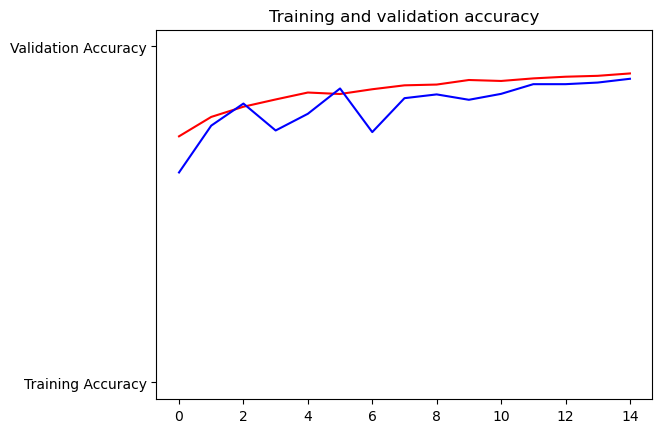

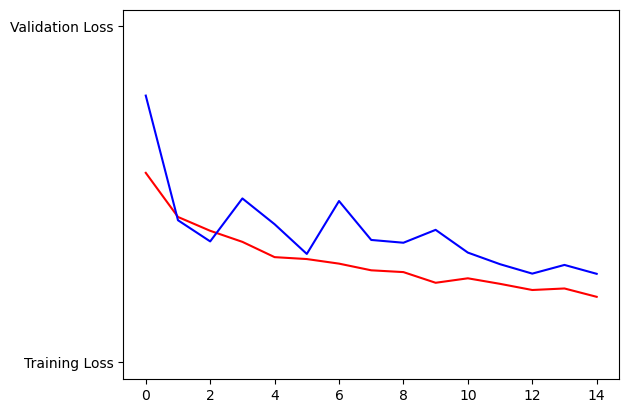

In [64]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()